In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
#from glob import glob

In [2]:
# file_pattern = 'BTCUSDT-trades-2024-01-*.csv'
# file_names = glob(file_pattern)

# total_df = pd.concat((pd.read_csv(f) for f in file_names), ignore_index=True)

# total_df.to_csv('BTCUSDT-trades-2024-01-combined.csv', index=False)

In [3]:
data = pd.read_csv('BTCUSDT-trades-2024-01-combined.csv')
data.head()

,id,price,qty,quote_qty,time,is_buyer_maker
0,4426785098,42314.0,0.033,1396.362,1704067200006,False
1,4426785099,42314.0,0.215,9097.510,1704067200006,False
2,4426785100,42314.0,0.100,4231.400,1704067200022,False
3,4426785101,42314.0,0.512,21664.768,1704067200022,False
4,4426785102,42314.0,0.007,296.198,1704067200022,False


In [4]:
def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """

    data['time'] = pd.to_datetime(data['time'], unit='ms')
    ohlcv = data.resample('1H', on='time').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum'
})

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

- 데이터에서 1시간 간격의 ohlcv 형식으로 변환하는 함수
- ohlcv로 주가 변동성 계산하는 함수

In [5]:
# 함수를 실행한 후 반환값을 변수에 저장
ohlcv_data = convert_tick_to_ohlcv(data)

print(ohlcv_data.head())

                        Open     High      Low    Close    Volume
time                                                             
2024-01-01 00:00:00  42314.0  42603.2  42289.6  42503.5  8459.477
2024-01-01 01:00:00  42503.5  42832.0  42462.0  42647.9  9043.411
2024-01-01 02:00:00  42647.9  42676.9  42530.0  42620.4  4653.067
2024-01-01 03:00:00  42620.5  42630.0  42270.0  42369.8  8119.880
2024-01-01 04:00:00  42369.8  42439.8  42235.2  42436.6  6356.536


In [6]:
# 648행
ohlcv_data.shape

(648, 5)

<Axes: >

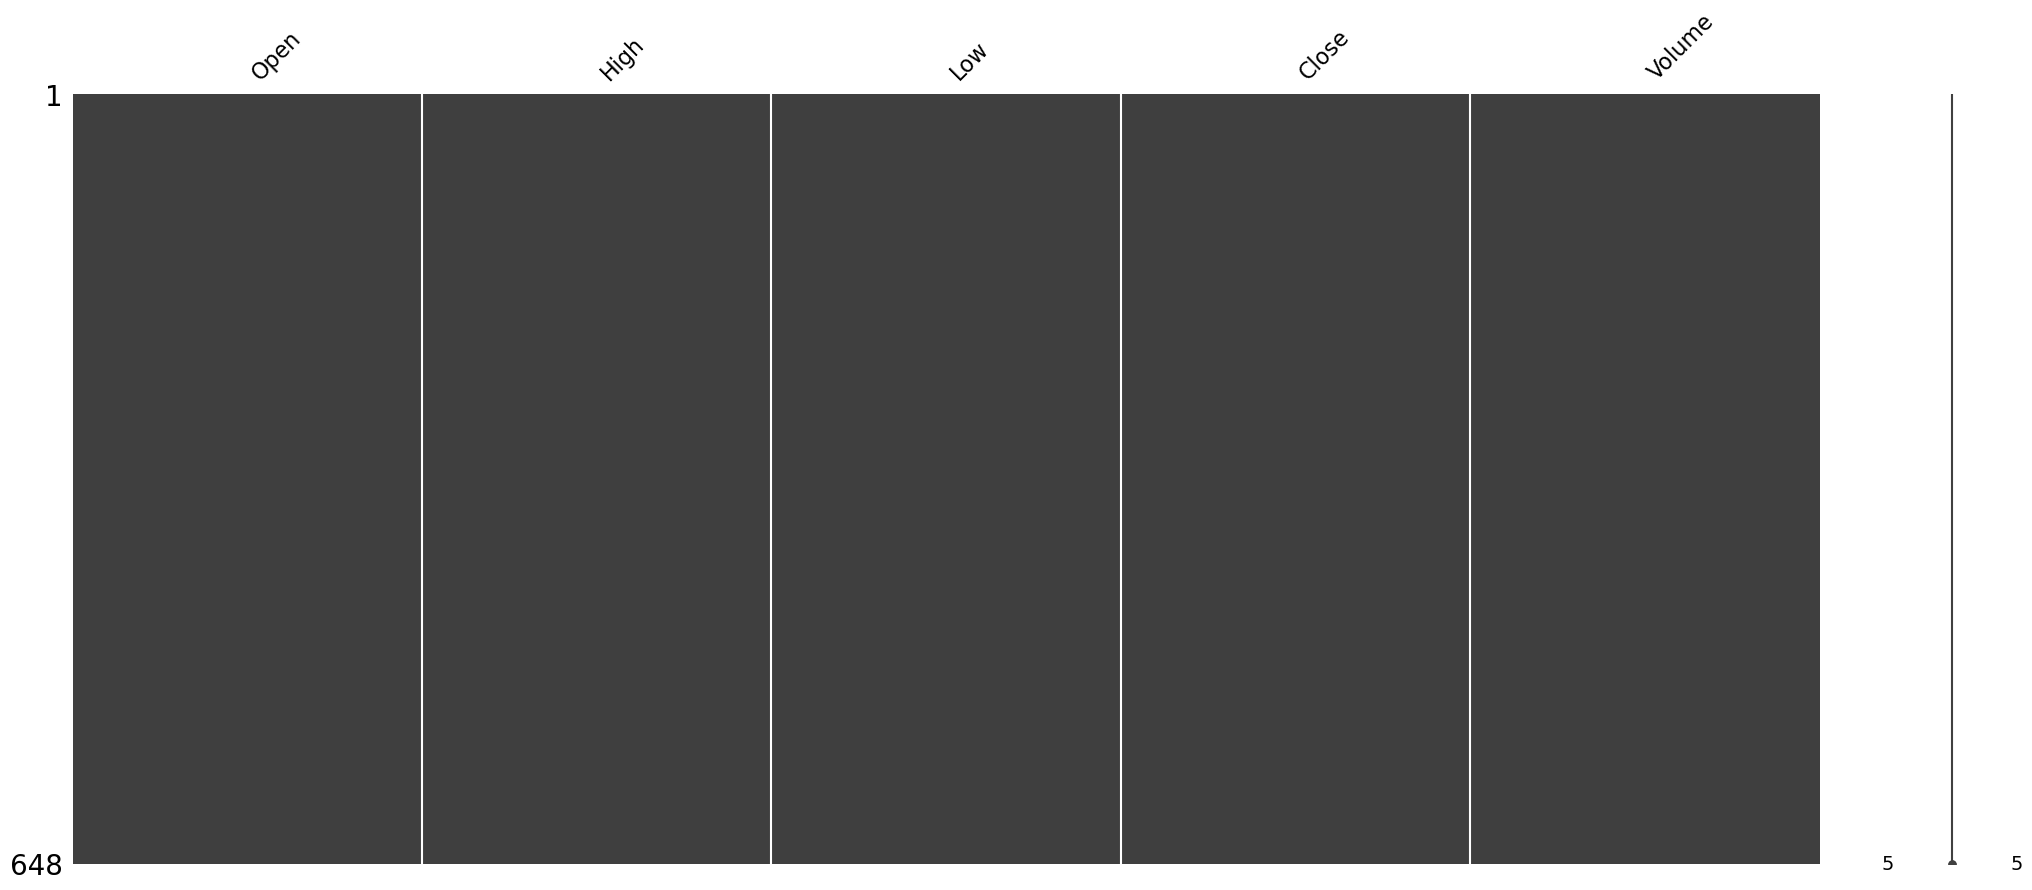

In [7]:
import missingno as msno
msno.matrix(ohlcv_data)

In [8]:
from sklearn.impute import KNNImputer
# K-최근접 이웃 방법으로 결측치 대체

# 파라미터 설정
imputer = KNNImputer(n_neighbors=5)

# fit_transform 메서드를 사용하여 결측치 대체
ohlcv_data_imputed = imputer.fit_transform(ohlcv_data)

# 결과를 DataFrame으로 변환
ohlcv_data_imputed = pd.DataFrame(ohlcv_data_imputed, columns=ohlcv_data.columns, index=ohlcv_data.index)

In [9]:
ohlcv_data_imputed.head()

,Open,High,Low,Close,Volume
time,,,,,
2024-01-01 00:00:00,42314.0,42603.2,42289.6,42503.5,8459.477
2024-01-01 01:00:00,42503.5,42832.0,42462.0,42647.9,9043.411
2024-01-01 02:00:00,42647.9,42676.9,42530.0,42620.4,4653.067
2024-01-01 03:00:00,42620.5,42630.0,42270.0,42369.8,8119.880
2024-01-01 04:00:00,42369.8,42439.8,42235.2,42436.6,6356.536


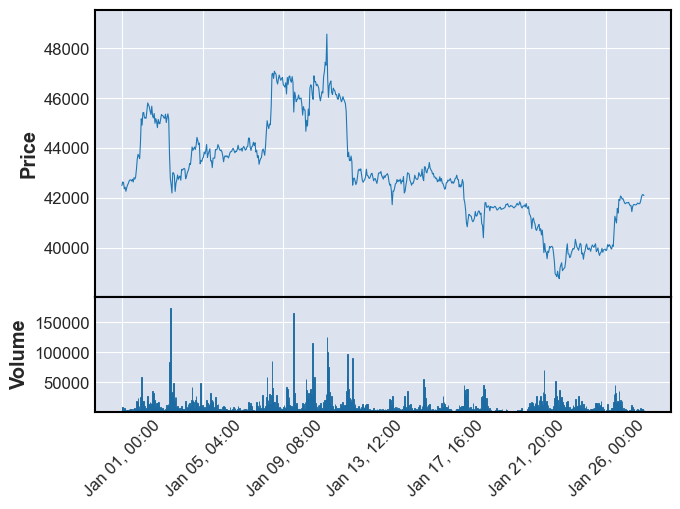

In [11]:
mpf.plot(ohlcv_data_imputed, volume = True, type='line')

In [12]:
Op=np.array(ohlcv_data_imputed["Open"])
Hi=np.array(ohlcv_data_imputed["High"])
Lo=np.array(ohlcv_data_imputed["Low"])
Cl=np.array(ohlcv_data_imputed["Close"])
V=np.array(ohlcv_data_imputed["Volume"])

In [13]:
input=np.column_stack((Op,Hi,Lo,V))
output=Cl

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

In [15]:
from sklearn.preprocessing import StandardScaler

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor
RF_sp = RandomForestRegressor()

In [17]:
# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [18]:
from sklearn.model_selection import GridSearchCV

# 그리드 서치
grid_search = GridSearchCV(RF_sp, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='explained_variance')

In [19]:
# 최적의 하이퍼파라미터
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

최적의 하이퍼파라미터: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [20]:
# 최적의 모델
RF_best = grid_search.best_estimator_

# 테스트 세트에 대한 예측
predictions = RF_best.predict(X_test_scaled)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# 모델 평가
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')
print(f'R-squared: {r_squared}')
print(f'Explained Variance Score: {explained_variance}')

mse: 17953.513363238108
rmse: 133.99072118336443
mae: 91.7455234455242
R-squared: 0.9952280335695185
Explained Variance Score: 0.9953310239780481


In [22]:
from sklearn.metrics import mean_absolute_percentage_error

mape_result = mean_absolute_percentage_error(y_test, predictions)
print(f'MAPE: {mape_result}')

MAPE: 0.002128078733417951


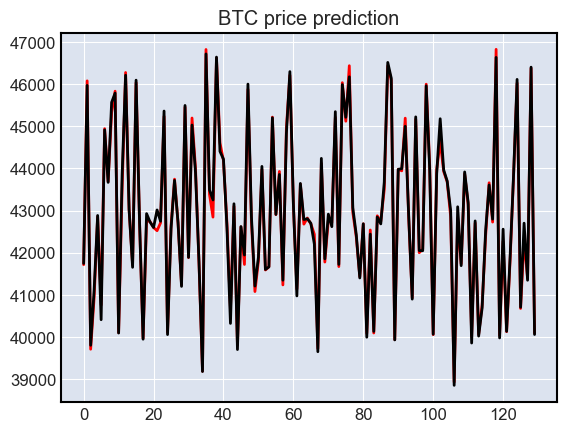

In [23]:
# 시각화

plt.plot(predictions, color='red')
plt.plot(y_test, color='black')
plt.title('BTC price prediction')
plt.show()

### 1월 28일~31일 Close 값 예측하기

In [24]:
# 1월 28일~31일 데이터프레임 형성

from datetime import datetime, timedelta

last_date = ohlcv_data_imputed.index.max()
next_date_start = last_date + timedelta(hours=1)
next_date_end = next_date_start + timedelta(days=3)

# 1시간 간격으로 조정
future_dates = pd.date_range(next_date_start, next_date_end, freq='H').values

future_dates = pd.DataFrame(index= future_dates, 
                            columns=ohlcv_data_imputed.columns)

# 총 73행
future_dates

,Open,High,Low,Close,Volume
2024-01-28 00:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-28 01:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-28 02:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-28 03:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-28 04:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-30 22:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-30 23:00:00,NaN,NaN,NaN,NaN,NaN


In [25]:
# 기존 데이터에 합치기

future = pd.concat([ohlcv_data_imputed, future_dates], axis=0)

In [26]:
future

,Open,High,Low,Close,Volume
2024-01-01 00:00:00,42314.0,42603.2,42289.6,42503.5,8459.477
2024-01-01 01:00:00,42503.5,42832.0,42462.0,42647.9,9043.411
2024-01-01 02:00:00,42647.9,42676.9,42530.0,42620.4,4653.067
2024-01-01 03:00:00,42620.5,42630.0,42270.0,42369.8,8119.880
2024-01-01 04:00:00,42369.8,42439.8,42235.2,42436.6,6356.536
...,...,...,...,...,...
2024-01-30 20:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-30 21:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-30 22:00:00,NaN,NaN,NaN,NaN,NaN
2024-01-30 23:00:00,NaN,NaN,NaN,NaN,NaN


In [27]:
# 결측치 확인

future.isnull().sum()

Open      73
High      73
Low       73
Close     73
Volume    73
dtype: int64

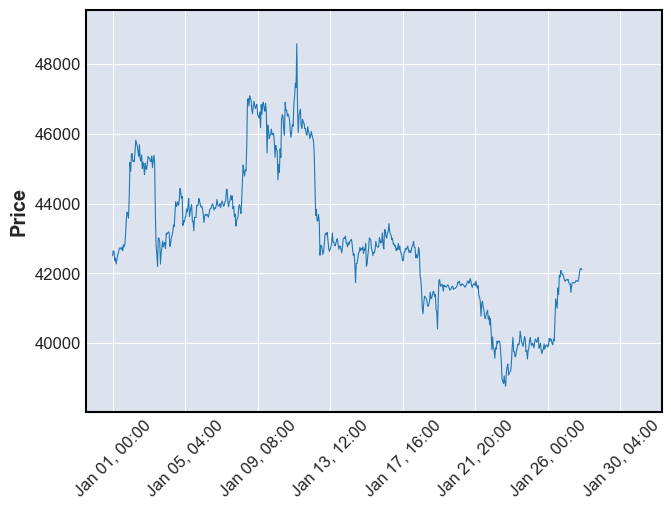

In [28]:
mpf.plot(future, type='line')

In [29]:
#from sklearn.impute import KNNImputer
# K-최근접 이웃 방법으로 결측치 대체

# 파라미터 설정
imputer = KNNImputer(n_neighbors=5)

# fit_transform 메서드를 사용하여 결측치 대체
future_imputed = imputer.fit_transform(future)

# 결과를 DataFrame으로 변환
future_imputed = pd.DataFrame(future_imputed, columns=future.columns, index=future.index)

In [31]:
Op=np.array(future_imputed["Open"])
Hi=np.array(future_imputed["High"])
Lo=np.array(future_imputed["Low"])
Cl=np.array(future_imputed["Close"])
V=np.array(future_imputed["Volume"])

In [32]:
input_future = np.column_stack((Op,Hi,Lo,V))
output_future=Cl

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_future, output_future, test_size=0.2, random_state=0)

In [34]:
# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 랜덤포레스트 모델로 다시 예측

In [40]:
RF_sp = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [41]:
# 그리드 서치
grid_search = GridSearchCV(RF_sp, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='explained_variance')

In [42]:
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

최적의 하이퍼파라미터: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [43]:
RF_best = grid_search.best_estimator_

In [44]:
predictions = RF_best.predict(X_test_scaled)

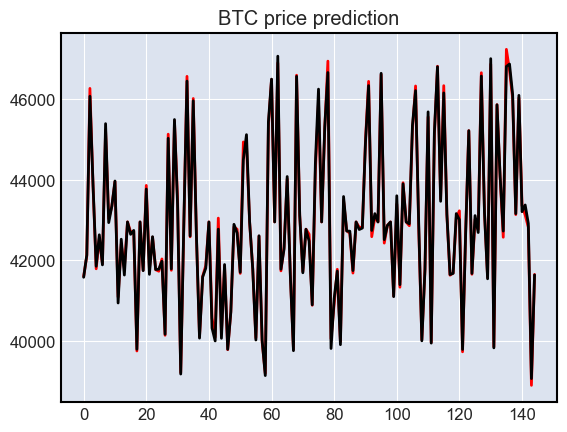

In [45]:
# 시각화

plt.plot(predictions, color='red')
plt.plot(y_test, color='black')
plt.title('BTC price prediction')
plt.show()

In [123]:
# 예측값 중 필요한 73개행 출력
predictions = pd.DataFrame(predictions[:73], columns=['Close'],
                          index=pd.to_datetime(future_dates.index))

predictions

,Close
2024-01-28 00:00:00,41714.942100
2024-01-28 01:00:00,46079.535500
2024-01-28 02:00:00,39707.883000
2024-01-28 03:00:00,40940.064500
2024-01-28 04:00:00,42859.207714
...,...
2024-01-30 20:00:00,44119.547000
2024-01-30 21:00:00,41777.425333
2024-01-30 22:00:00,42772.292500
2024-01-30 23:00:00,42706.857106


In [124]:
# 모든 행 출력

pd.set_option('display.max_rows',None)

predictions

,Close
2024-01-28 00:00:00,41714.942100
2024-01-28 01:00:00,46079.535500
2024-01-28 02:00:00,39707.883000
2024-01-28 03:00:00,40940.064500
2024-01-28 04:00:00,42859.207714
2024-01-28 05:00:00,40757.748000
2024-01-28 06:00:00,44944.103000
2024-01-28 07:00:00,43686.692500
2024-01-28 08:00:00,45326.661500
2024-01-28 09:00:00,45834.314000


In [125]:
# predictions_df 데이터프레임 생성
predictions_df = pd.DataFrame(predictions)

# 열 이름 확인
print(predictions_df.columns)

Index(['Close'], dtype='object')


# 예측

In [145]:
existing_csv_path = '[ASCENDxBDA] submission.csv'

In [146]:
# 데이터프레임 생성
predictions_df = pd.DataFrame(predictions)

In [147]:
existing_df = pd.read_csv(existing_csv_path)

In [148]:
# 'Unnamed: 0' 열을 날짜 형식으로 변환
existing_df['Unnamed: 0'] = pd.to_datetime(existing_df['Unnamed: 0'])

In [149]:
# 'Unnamed: 0' 열을 인덱스로 설정
existing_df.set_index('Unnamed: 0', inplace=True)

In [150]:
# 'Close' 값을 'pred_volatility' 열로 복사
existing_df['pred_volatility'] = predictions_df['Close']

In [153]:
# 파일에 저장
existing_df.to_csv(existing_csv_path)

In [195]:
btc = existing_df
btc.tail()

,pred_volatility
Unnamed: 0,
2024-01-30 20:00:00,44119.547000
2024-01-30 21:00:00,41777.425333
2024-01-30 22:00:00,42772.292500
2024-01-30 23:00:00,42706.857106
2024-01-31 00:00:00,45213.320500


In [214]:
# 데이터프레임 생성
pred = pd.DataFrame(btc)
pred.set_index('pred_volatility', inplace=True)

In [216]:
# 특성과 타겟 분리
X = np.array(pred.index.astype(int) / 10**9).reshape(-1, 1)  # timestamp를 초 단위로 변환
y = pred.index.values

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [218]:
from sklearn.preprocessing import StandardScaler

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [219]:
RF_sp = RandomForestRegressor()

In [220]:
# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [221]:
from sklearn.model_selection import GridSearchCV

# 그리드 서치
grid_search = GridSearchCV(RF_sp, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='explained_variance')

In [222]:
# 최적의 하이퍼파라미터
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

최적의 하이퍼파라미터: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [223]:
# 최적의 모델
RF_best = grid_search.best_estimator_

# 테스트 세트에 대한 예측
predictions = RF_best.predict(X_test_scaled)

In [224]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# 모델 평가
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')
print(f'R-squared: {r_squared}')
print(f'Explained Variance Score: {explained_variance}')

mse: 1853.9684458972986
rmse: 43.05773386857811
mae: 28.857453860003442
R-squared: 0.9992497729864079
Explained Variance Score: 0.9993170590559464


In [225]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE 계산
mape_result = mean_absolute_percentage_error(y_test, predictions)
print(f'MAPE: {mape_result}')

MAPE: 0.0006746136861394932
